In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs               
import cartopy.feature as cfeature         
import cartopy.util as cutil
import xarray as xr                        
import numpy as np
import pandas as pd
import plotting_module
import xesmf as xe

In [2]:
ozone_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.O3.200201-202412.nc")
pdeldry_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.PDELDRY.200201-202412.nc")
ps_dataset = xr.open_dataset('/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.PS.200201-202412.nc')

In [3]:
ozone = ozone_dataset["O3"]

In [4]:
p0 = ozone_dataset["P0"]
hyai = ozone_dataset["hyai"]
hybi = ozone_dataset["hybi"]
ps = ps_dataset['PS']
pdeldry = pdeldry_dataset['PDELDRY']
lev = ozone_dataset.coords['lev']
num_lev = lev.shape[0]

# convert to hPa from Pa
p0 = p0.copy() / 100
ps = ps.copy() / 100
pdeldry = pdeldry.copy() / 100 

# truncate to levels 16-31
truncated_pdeldry = pdeldry.isel({pdeldry.dims[1]: slice(17, 31)})
truncated_ozone = ozone.isel({ozone.dims[1]: slice(17, 31)})

In [5]:
hyai

<xarray.DataArray 'hyai' (ilev: 33)> Size: 264B
[33 values with dtype=float64]
Coordinates:
  * ilev     (ilev) float64 264B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
Attributes:
    long_name:  hybrid A coefficient at layer interfaces

In [6]:
hybi

<xarray.DataArray 'hybi' (ilev: 33)> Size: 264B
[33 values with dtype=float64]
Coordinates:
  * ilev     (ilev) float64 264B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
Attributes:
    long_name:  hybrid B coefficient at layer interfaces

In [7]:
truncated_pdeldry

<xarray.DataArray 'PDELDRY' (time: 276, lev: 14, lat: 192, lon: 288)> Size: 855MB
array([[[[32.03059  , 32.03059  , 32.03059  , ..., 32.03059  ,
          32.03059  , 32.03059  ],
         [32.762924 , 32.74487  , 32.724735 , ..., 32.81732  ,
          32.799374 , 32.78059  ],
         [33.262253 , 33.223904 , 33.184464 , ..., 33.375416 ,
          33.338024 , 33.300106 ],
         ...,
         [52.920753 , 52.9196   , 52.918533 , ..., 52.924477 ,
          52.92318  , 52.921932 ],
         [53.001644 , 53.001156 , 53.000683 , ..., 53.003258 ,
          53.002697 , 53.002163 ],
         [53.064163 , 53.064163 , 53.064163 , ..., 53.064163 ,
          53.064163 , 53.064163 ]],

        [[37.68184  , 37.68184  , 37.68184  , ..., 37.68184  ,
          37.68184  , 37.68184  ],
         [38.543324 , 38.522083 , 38.498398 , ..., 38.607323 ,
          38.586212 , 38.56411  ],
         [39.130684 , 39.085567 , 39.03917  , ..., 39.26381  ,
          39.219822 , 39.175213 ],
...
         [20.3775   , 20.377659 , 20.377857 , ..., 20.377094 ,
          20.377209 , 20.37735  ],
         [20.410372 , 20.410381 , 20.410395 , ..., 20.410425 ,
          20.410387 , 20.410374 ],
         [20.437185 , 20.437185 , 20.437185 , ..., 20.437185 ,
          20.437185 , 20.437185 ]],

        [[10.710202 , 10.710202 , 10.710202 , ..., 10.710202 ,
          10.710202 , 10.710202 ],
         [10.959317 , 10.953091 , 10.946158 , ..., 10.9780445,
          10.9718685, 10.965405 ],
         [11.126788 , 11.113623 , 11.1001005, ..., 11.16568  ,
          11.152833 , 11.139801 ],
         ...,
         [17.812803 , 17.812939 , 17.813108 , ..., 17.812462 ,
          17.81256  , 17.812677 ],
         [17.8414   , 17.841408 , 17.841423 , ..., 17.841446 ,
          17.841412 , 17.8414   ],
         [17.864948 , 17.864948 , 17.864948 , ..., 17.864948 ,
          17.864948 , 17.864948 ]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 112B 322.2 379.1 446.0 524.7 ... 936.2 957.5 976.3
  * time     (time) datetime64[ns] 2kB 2002-02-01 2002-03-01 ... 2025-01-01

Now group 'ozone' and 'pdeldry' DataArrays by months

In [8]:
start_date = '2005-02-01'
end_date = '2025-01-01'

# group the 240 month dates based on calendar months for both PDELDRY and O3 variables

truncated_pdeldry = truncated_pdeldry.sel(time=slice(start_date, end_date))
pdeldry_monthly_mean = truncated_pdeldry.groupby('time.month').mean('time')
pdeldry_monthly_mean = pdeldry_monthly_mean.transpose('lev','month','lat','lon')

truncated_ozone = truncated_ozone.sel(time=slice(start_date, end_date))
ozone_monthly_mean = truncated_ozone.groupby('time.month').mean('time')
ozone_monthly_mean = ozone_monthly_mean.transpose('lev','month','lat','lon')

In [9]:
# constants / conversion factor
NAv = 6.0221415e+23                       # molecules in mole
g = 9.81                                  # gravity
MWair = 28.94                             # g/mol
xp_const = (NAv * 10)/(MWair*g)           # scaling factor, pa to hPa and cm to m
DU_CONVERSION = 2.69 * 10**16

In [10]:
# Initialize pressure edge arrays
mod_press_low = xr.zeros_like(ozone).transpose('lev','lat','lon','time')
mod_press_top = xr.zeros_like(ozone).transpose('lev','lat','lon','time')

Calculating pressure at hybrid levels

p(k) = a(k) * p0 + b(k) * ps

In [11]:
# Calculate pressure edge arrays
# CAM-chem layer indices start at the top and end at the bottom
for i in range(num_lev):
    mod_press_top[i,:,:,:] = hyai[i]*p0 + hybi[i]*ps

In [12]:
mod_press_top = mod_press_top.transpose('lev', 'time', 'lat', 'lon')

<xarray.DataArray 'O3' (lev: 32, time: 276, lat: 192, lon: 288)> Size: 2GB
array([[[[   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395],
         [   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395],
         [   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395],
         ...,
         [   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395],
         [   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395],
         [   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395]],

        [[   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395],
         [   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395],
         [   2.2552395,    2.2552395,    2.2552395, ...,    2.2552395,
             2.2552395,    2.2552395],
...
         [ 989.52435  ,  989.49304  ,  989.46155  , ...,  989.62006  ,
           989.5889   ,  989.5571   ],
         [ 989.9837   ,  989.9632   ,  989.94257  , ...,  990.0438   ,
           990.0243   ,  990.0042   ],
         [ 990.06213  ,  990.06213  ,  990.06213  , ...,  990.06213  ,
           990.06213  ,  990.06213  ]],

        [[ 671.6047   ,  671.6047   ,  671.6047   , ...,  671.6047   ,
           671.6047   ,  671.6047   ],
         [ 683.00336  ,  682.71826  ,  682.40094  , ...,  683.8606   ,
           683.5779   ,  683.28204  ],
         [ 690.67365  ,  690.0708   ,  689.4515   , ...,  692.4548   ,
           691.8663   ,  691.26953  ],
         ...,
         [ 996.54083  ,  996.54663  ,  996.554    , ...,  996.52594  ,
           996.5302   ,  996.53534  ],
         [ 997.8217   ,  997.82214  ,  997.8227   , ...,  997.8238   ,
           997.82227  ,  997.8217   ],
         [ 998.8832   ,  998.8832   ,  998.8832   , ...,  998.8832   ,
           998.8832   ,  998.8832   ]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time     (time) datetime64[ns] 2kB 2002-02-01 2002-03-01 ... 2025-01-01
Attributes:
    mdims:         1
    units:         mol/mol
    mixing_ratio:  dry
    long_name:     O3 concentration
    cell_methods:  time: mean

In [40]:
mod_press_top = mod_press_top.transpose('time', 'lat', 'lon', 'lev')
mod_press_top

<xarray.DataArray 'O3' (time: 276, lat: 192, lon: 288, lev: 32)> Size: 2GB
array([[[[   2.2552395,    5.031692 ,   10.157948 , ...,  651.1982   ,
           663.5244   ,  674.2979   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  651.1982   ,
           663.5244   ,  674.2979   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  651.1982   ,
           663.5244   ,  674.2979   ],
         ...,
         [   2.2552395,    5.031692 ,   10.157948 , ...,  651.1982   ,
           663.5244   ,  674.2979   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  651.1982   ,
           663.5244   ,  674.2979   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  651.1982   ,
           663.5244   ,  674.2979   ]],

        [[   2.2552395,    5.031692 ,   10.157948 , ...,  661.92914  ,
           674.53723  ,  685.55707  ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  661.6646   ,
           674.2657   ,  685.2795   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  661.3697   ,
           673.9631   ,  684.9701   ],
...
         [   2.2552395,    5.031692 ,   10.157948 , ...,  959.5476   ,
           979.9721   ,  997.8238   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  959.5462   ,
           979.97064  ,  997.82227  ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  959.54565  ,
           979.9701   ,  997.8217   ]],

        [[   2.2552395,    5.031692 ,   10.157948 , ...,  960.5574   ,
           981.00836  ,  998.8832   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  960.5574   ,
           981.00836  ,  998.8832   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  960.5574   ,
           981.00836  ,  998.8832   ],
         ...,
         [   2.2552395,    5.031692 ,   10.157948 , ...,  960.5574   ,
           981.00836  ,  998.8832   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  960.5574   ,
           981.00836  ,  998.8832   ],
         [   2.2552395,    5.031692 ,   10.157948 , ...,  960.5574   ,
           981.00836  ,  998.8832   ]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time     (time) datetime64[ns] 2kB 2002-02-01 2002-03-01 ... 2025-01-01
Attributes:
    mdims:         1
    units:         mol/mol
    mixing_ratio:  dry
    long_name:     O3 concentration
    cell_methods:  time: mean

In [43]:
mod_press_top[36][125][213] # everest

<xarray.DataArray 'O3' (lev: 32)> Size: 128B
array([   2.2552395,    5.031692 ,   10.157948 ,   18.555317 ,
         29.734676 ,   39.273003 ,   47.1145   ,   56.240498 ,
         66.8005   ,   80.701416 ,   94.94104  ,  111.693214 ,
        131.40128  ,  154.5868   ,  181.86336  ,  214.8144   ,
        253.5796   ,  299.18484  ,  352.8371   ,  415.95612  ,
        490.21243  ,  577.5711   ,  664.9648   ,  745.175    ,
        812.862    ,  863.16797  ,  892.2916   ,  919.61487  ,
        944.91626  ,  967.98737  ,  988.6335   , 1006.6789   ],
      dtype=float32)
Coordinates:
    lat      float64 8B 27.8
    lon      float64 8B 266.2
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
    time     datetime64[ns] 8B 2005-02-01
Attributes:
    mdims:         1
    units:         mol/mol
    mixing_ratio:  dry
    long_name:     O3 concentration
    cell_methods:  time: mean

In [66]:
#mod_press_top[36][138][60]
mod_press_top[36][138][60]

<xarray.DataArray 'O3' (lev: 32)> Size: 128B
array([  2.2552395,   5.031692 ,  10.157948 ,  18.555317 ,  29.734676 ,
        39.273003 ,  47.1145   ,  56.240498 ,  66.8005   ,  80.701416 ,
        94.94104  , 111.693214 , 131.40128  , 154.5868   , 181.86336  ,
       202.254    , 226.24251  , 254.46378  , 287.66464  , 326.7237   ,
       372.67468  , 426.73364  , 480.8142   , 530.4496   , 572.3354   ,
       603.4655   , 621.48773  , 638.39575  , 654.0527   , 668.32947  ,
       681.1056   , 692.2724   ], dtype=float32)
Coordinates:
    lat      float64 8B 40.05
    lon      float64 8B 75.0
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
    time     datetime64[ns] 8B 2005-02-01
Attributes:
    mdims:         1
    units:         mol/mol
    mixing_ratio:  dry
    long_name:     O3 concentration
    cell_methods:  time: mean

In [57]:
mod_press_top[36][120][20]

<xarray.DataArray 'O3' (lev: 32)> Size: 128B
array([  2.2552395,   5.031692 ,  10.157948 ,  18.555317 ,  29.734676 ,
        39.273003 ,  47.1145   ,  56.240498 ,  66.8005   ,  80.701416 ,
        94.94104  , 111.693214 , 131.40128  , 154.5868   , 181.86336  ,
       211.82721  , 247.07814  , 288.54904  , 337.3374   , 394.73434  ,
       462.25894  , 541.69806  , 621.16907  , 694.1078   , 755.65857  ,
       801.40405  , 827.8875   , 852.7337   , 875.7414   , 896.721    ,
       915.4955   , 931.90497  ], dtype=float32)
Coordinates:
    lat      float64 8B 23.09
    lon      float64 8B 25.0
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
    time     datetime64[ns] 8B 2005-02-01
Attributes:
    mdims:         1
    units:         mol/mol
    mixing_ratio:  dry
    long_name:     O3 concentration
    cell_methods:  time: mean

In [13]:
filtered_300hpa_upper = mod_press_top.where(mod_press_top >= 300, drop=False)
filtered_300hpa_upper = filtered_300hpa_upper.where(mod_press_top < 322.24, drop=False)

In [14]:
mod_deltap = abs(300 - filtered_300hpa_upper)

In [15]:
mod_deltap[18][37][10]

<xarray.DataArray 'O3' (lon: 288)> Size: 1kB
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
...
       13.525787  , 12.396393  , 11.274048  , 10.153717  ,  9.029724  ,
        7.905182  ,  6.7829895 ,  5.6727905 ,  4.57666   ,  3.4949646 ,
        2.437683  ,  1.4144592 ,  0.43814087,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        1.079956  ,  2.874237  ,  5.05777   ,  7.6170654 , 10.506317  ,
       13.66217   , 16.990387  , 20.375732  ,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, 21.816803  , 20.119446  ,
       18.441742  , 16.772247  , 15.099182  , 13.415527  , 11.719421  ,
       10.011749  ,  8.313843  ,  6.666443  ,  5.1027527 ,  3.641449  ,
        2.2881165 ,  1.0390015 ,         nan,         nan,         nan,
               nan,         nan,         nan], dtype=float32)
Coordinates:
    lat      float64 8B -80.58
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev      float64 8B 379.1
    time     datetime64[ns] 8B 2005-03-01

In [16]:
ozone_filtered = ozone.where(mod_deltap.notnull())
ozone_filtered = ozone_filtered.transpose('lev','time','lat','lon')

In [17]:
mod_deltap_filtered = mod_deltap.where(ozone_filtered.notnull())

In [18]:
# check if data array is all NaN
mod_deltap_filtered.mean(dim={'lev', 'time','lat','lon'}, skipna=True)

<xarray.DataArray 'O3' ()> Size: 4B
array(12.481593, dtype=float32)

In [19]:
mod_deltap_filtered

<xarray.DataArray 'O3' (lev: 32, time: 276, lat: 192, lon: 288)> Size: 2GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time     (time) datetime64[ns] 2kB 2002-02-01 2002-03-01 ... 2025-01-01

In [20]:
mod_deltap_filtered = mod_deltap_filtered.fillna(0)
ozone_filtered = ozone_filtered.fillna(0)

In [21]:
mod_deltap_filtered[17][36][10]

<xarray.DataArray 'O3' (lon: 288)> Size: 1kB
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
Coordinates:
    lat      float64 8B -80.58
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev      float64 8B 322.2
    time     datetime64[ns] 8B 2005-02-01

In [22]:
mod_deltap_filtered = mod_deltap_filtered.sel(time=slice(start_date, end_date))
ozone_filtered = ozone_filtered.sel(time=slice(start_date, end_date))

mod_deltap_filtered = mod_deltap_filtered.groupby('time.month').mean('time')
ozone_filtered = ozone_filtered.groupby('time.month').mean('time')

Calculating ozone column for [300hPa, 322.24hPa) and averaging it

In [23]:
ozone_300hpa_column = xr.dot(mod_deltap_filtered, xp_const*ozone_filtered, dims='lev')

In [24]:
ozone_du_300hpa_column = ozone_300hpa_column.copy() / DU_CONVERSION

ozone_du_300hpa_column = ozone_du_300hpa_column.where(ozone_du_300hpa_column != 0)

In [25]:
#ozone_du_300hpa_column = ozone_du_300hpa_column.sel(time=slice(start_date, end_date))
#ozone_du_300hpa_column = ozone_du_300hpa_column.groupby('time.month').mean('time')

Now calculating ozone column from 322.24hPa to ground level

In [26]:
ozone_part_column = xr.dot(pdeldry_monthly_mean, xp_const*ozone_monthly_mean, dims='lev')

In [27]:
ozone_du_column = ozone_part_column.copy() / DU_CONVERSION

Now calculate total tropospheric column ozone

In [28]:
ozone_du_300hpa_column = ozone_du_300hpa_column.fillna(0)
total_tco = ozone_du_column + ozone_du_300hpa_column

In [29]:
total_tco

<xarray.DataArray (month: 12, lat: 192, lon: 288)> Size: 3MB
array([[[14.507327 , 14.507327 , 14.507327 , ..., 14.507327 ,
         14.507327 , 14.507327 ],
        [14.022245 , 14.019872 , 14.016877 , ..., 14.028714 ,
         14.026558 , 14.024278 ],
        [14.116002 , 14.110451 , 14.104628 , ..., 14.131857 ,
         14.126719 , 14.121365 ],
        ...,
        [27.93736  , 27.934855 , 27.932417 , ..., 27.94507  ,
         27.942562 , 27.939943 ],
        [27.962563 , 27.960697 , 27.95884  , ..., 27.968204 ,
         27.966349 , 27.96446  ],
        [28.049376 , 28.049376 , 28.049376 , ..., 28.049376 ,
         28.049376 , 28.049376 ]],

       [[16.031769 , 16.031769 , 16.031769 , ..., 16.03177  ,
         16.03177  , 16.031769 ],
        [15.475872 , 15.475131 , 15.473646 , ..., 15.479452 ,
         15.478092 , 15.476693 ],
        [15.523313 , 15.521136 , 15.518532 , ..., 15.530867 ,
         15.528171 , 15.525593 ],
...
        [27.652391 , 27.65078  , 27.649117 , ..., 27.656425 ,
         27.655214 , 27.653902 ],
        [27.71675  , 27.715374 , 27.714027 , ..., 27.721504 ,
         27.719873 , 27.718256 ],
        [27.756077 , 27.756075 , 27.756077 , ..., 27.756077 ,
         27.756075 , 27.756075 ]],

       [[12.982155 , 12.982155 , 12.982155 , ..., 12.982155 ,
         12.982155 , 12.982155 ],
        [12.557584 , 12.568321 , 12.581455 , ..., 12.555739 ,
         12.553475 , 12.550985 ],
        [12.710565 , 12.705241 , 12.699593 , ..., 12.725997 ,
         12.720944 , 12.7157545],
        ...,
        [27.709557 , 27.706974 , 27.704315 , ..., 27.71719  ,
         27.714592 , 27.712025 ],
        [27.770191 , 27.768158 , 27.766119 , ..., 27.776371 ,
         27.774311 , 27.772234 ],
        [27.810656 , 27.810661 , 27.810654 , ..., 27.810656 ,
         27.810656 , 27.81066  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Regridding and plotting

In [30]:
omi_mls_ds = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_mean_2005_2024.nc")
omi_mls_ds = omi_mls_ds.rename({'latitude': 'lat', 'longitude': 'lon'})

# shifting lon to be 0-360
omi_mls_ds['lon'] = omi_mls_ds['lon'] % 360
omi_mls_ds = omi_mls_ds.sortby('lon')

In [31]:
#ozone_du_column_regridded = ozone_du_column.interp(coords=dict(lat=omi_mls_ds.lat, lon=omi_mls_ds.lon), method='linear')
regridder = xe.Regridder(total_tco, omi_mls_ds, 'bilinear', periodic=True)                                                                             

In [32]:
cesm_regridded = regridder(total_tco)

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [33]:
cesm_regridded

<xarray.DataArray (month: 12, lat: 180, lon: 360)> Size: 3MB
array([[[14.249446 , 14.248378 , 14.247116 , ..., 14.252253 ,
         14.251275 , 14.250381 ],
        [14.076025 , 14.0725355, 14.068796 , ..., 14.08582  ,
         14.082546 , 14.079328 ],
        [14.147688 , 14.1417885, 14.135972 , ..., 14.164959 ,
         14.159412 , 14.153602 ],
        ...,
        [27.908203 , 27.907114 , 27.90617  , ..., 27.912683 ,
         27.910963 , 27.909477 ],
        [27.94675  , 27.944965 , 27.943207 , ..., 27.952274 ,
         27.950417 , 27.94857  ],
        [28.002918 , 28.002129 , 28.00134  , ..., 28.005325 ,
         28.004522 , 28.003717 ]],

       [[15.736661 , 15.736273 , 15.735654 , ..., 15.738014 ,
         15.737408 , 15.736993 ],
        [15.503309 , 15.501924 , 15.500203 , ..., 15.507722 ,
         15.506047 , 15.504619 ],
        [15.550189 , 15.546894 , 15.543501 , ..., 15.559403 ,
         15.556515 , 15.553409 ],
...
        [27.63324  , 27.63188  , 27.630424 , ..., 27.636997 ,
         27.635729 , 27.634506 ],
        [27.678059 , 27.676846 , 27.675621 , ..., 27.681618 ,
         27.680464 , 27.679268 ],
        [27.734919 , 27.734337 , 27.733767 , ..., 27.736868 ,
         27.736181 , 27.735529 ]],

       [[12.759163 , 12.763979 , 12.769562 , ..., 12.754717 ,
         12.753652 , 12.755484 ],
        [12.648604 , 12.649744 , 12.651353 , ..., 12.652561 ,
         12.649301 , 12.648262 ],
        [12.792905 , 12.78805  , 12.783485 , ..., 12.808021 ,
         12.803015 , 12.797934 ],
        ...,
        [27.66461  , 27.66111  , 27.657566 , ..., 27.675354 ,
         27.671652 , 27.6681   ],
        [27.733368 , 27.731472 , 27.729551 , ..., 27.738977 ,
         27.73708  , 27.735228 ],
        [27.788755 , 27.787893 , 27.787025 , ..., 27.791372 ,
         27.790491 , 27.78962  ]]], dtype=float32)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    regrid_method:  bilinear

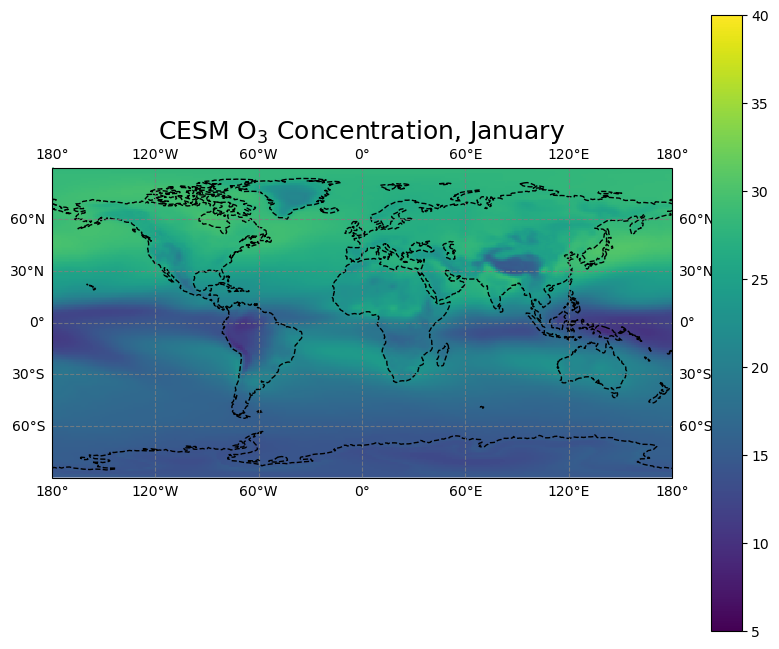

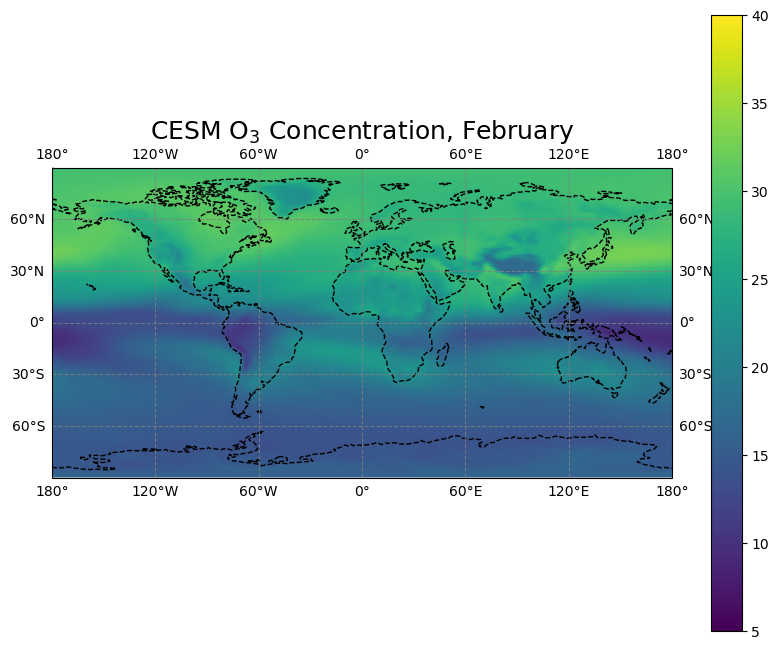

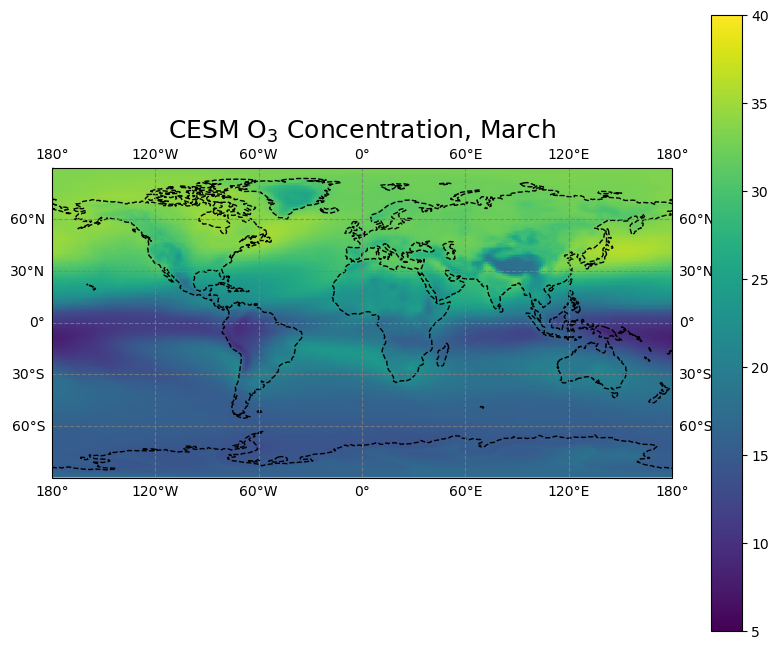

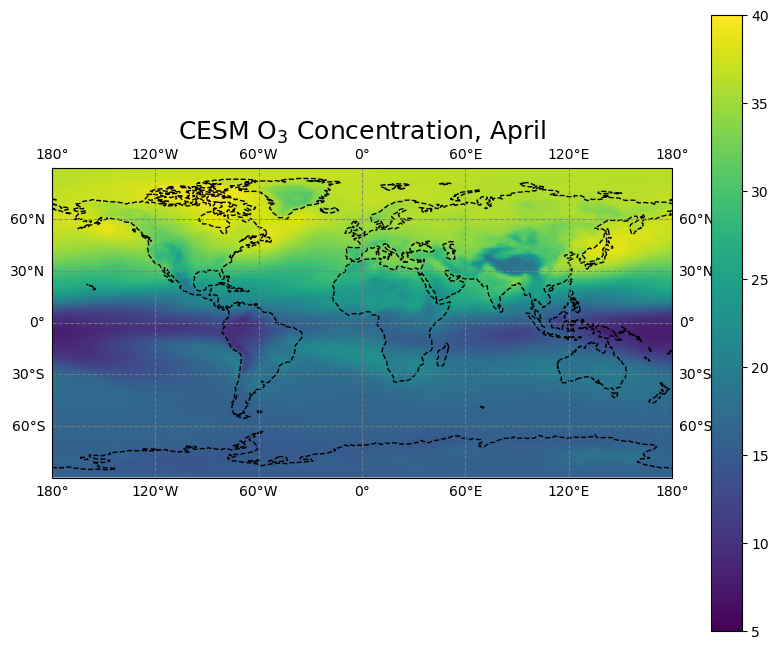

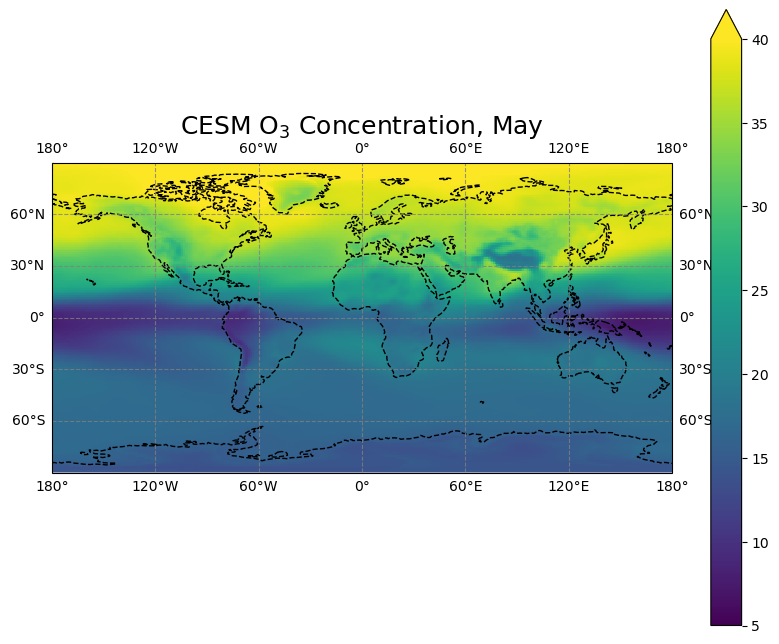

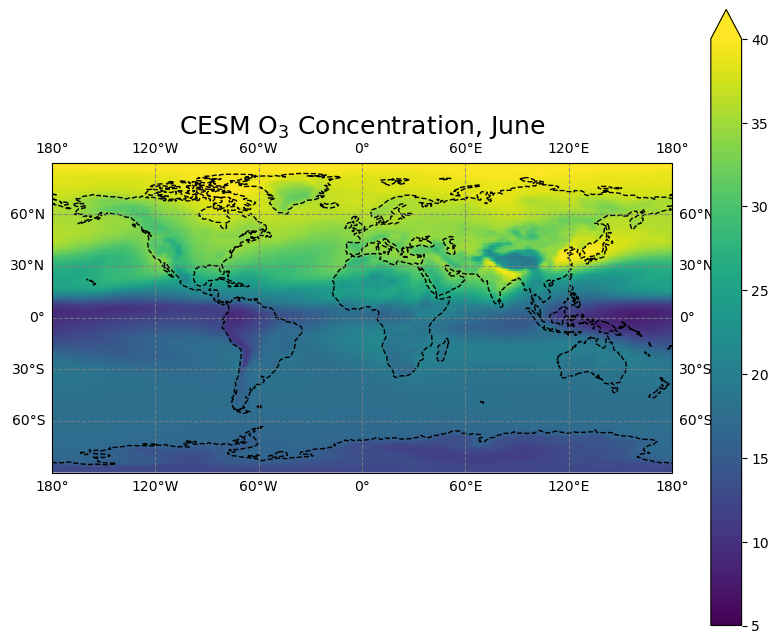

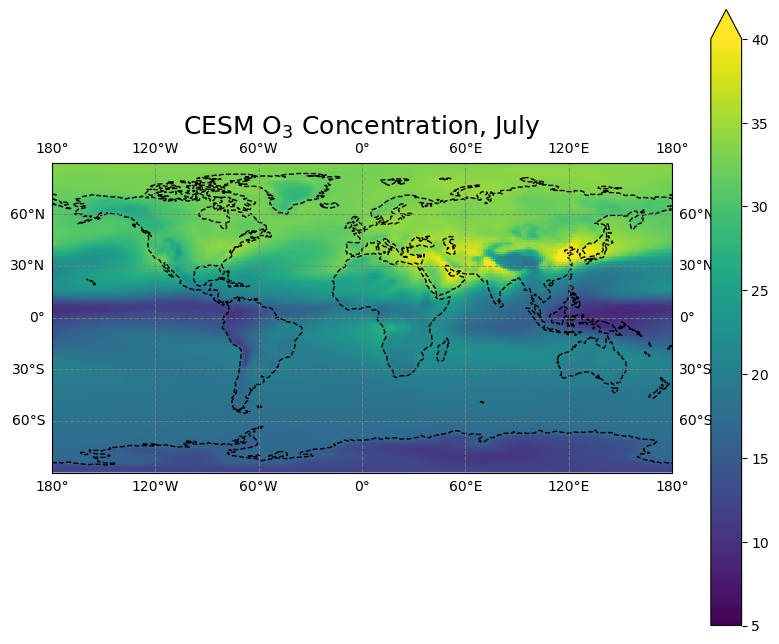

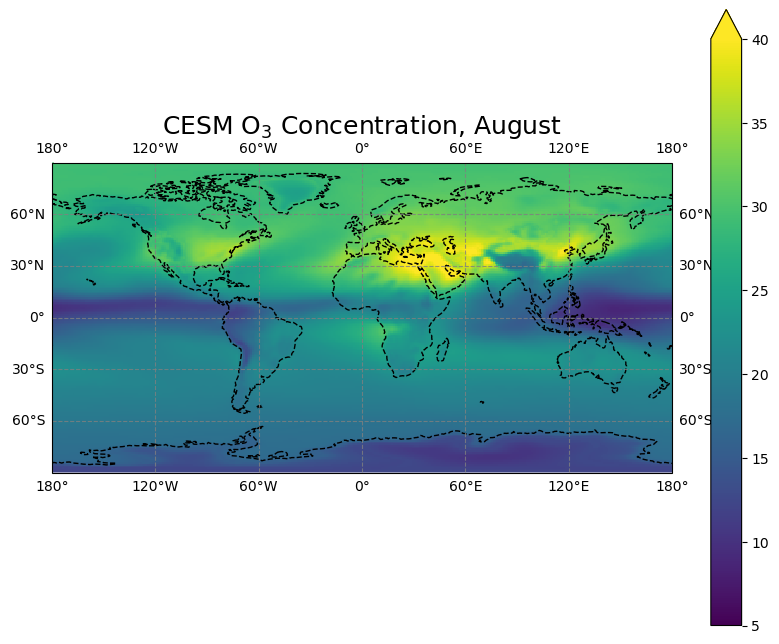

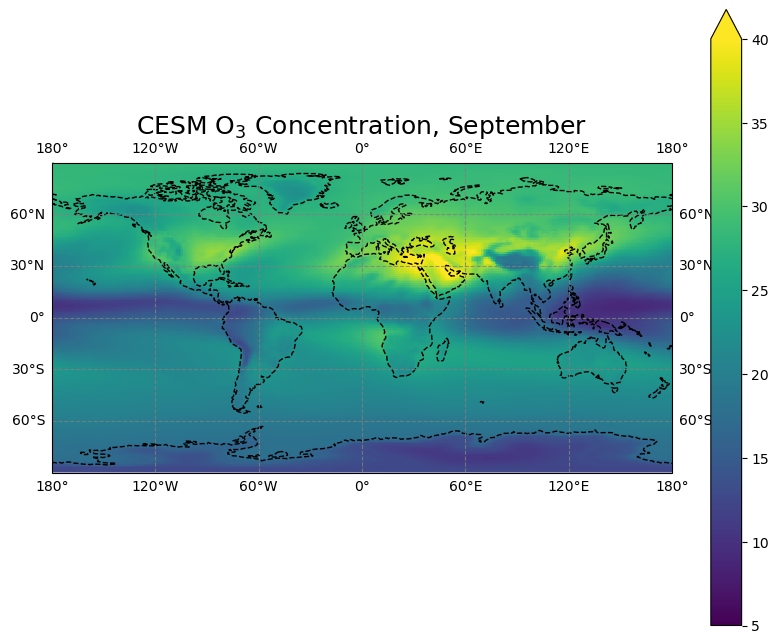

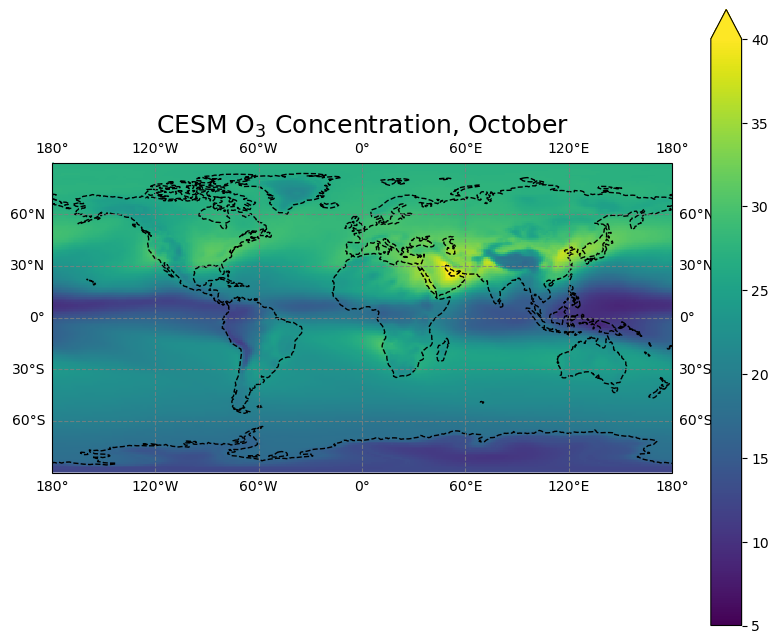

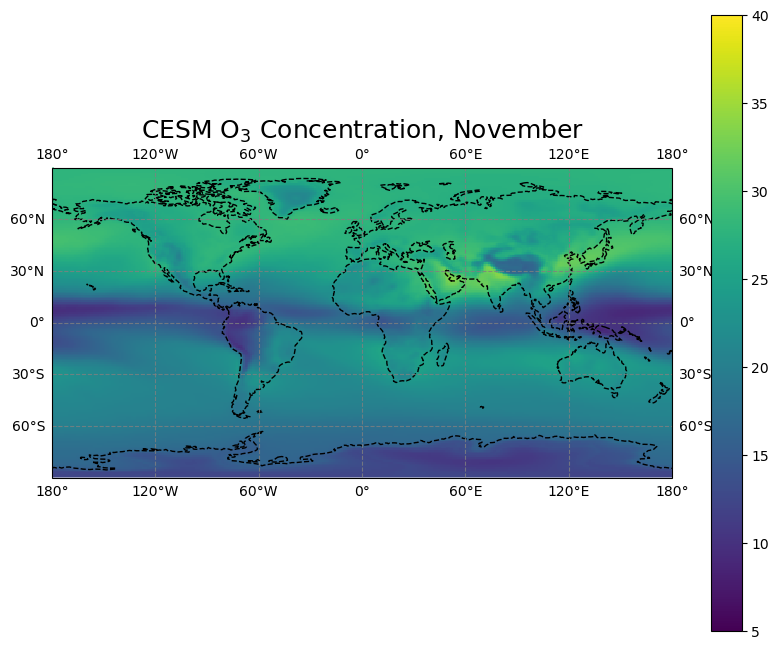

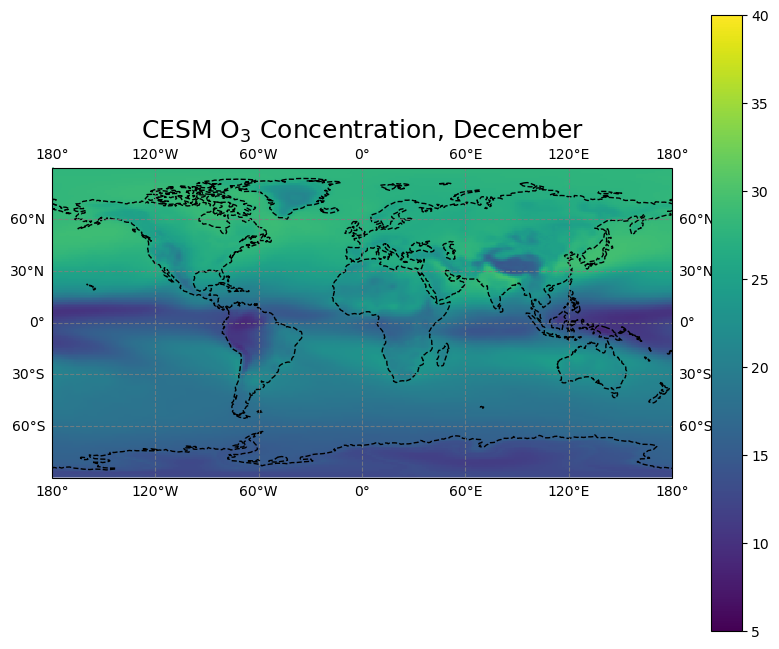

In [34]:
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for i in range(12):
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # plotting data
    cesm_regridded[i].plot(vmin=5, vmax=40)
    
    ax.set_title("CESM $\mathregular{O_3}$ Concentration, "+ str(month_list[i]), fontsize=18)
    
    # add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='--')

    # add lat lon grids
    gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.8, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    plt.show()

In [35]:
difference = cesm_regridded - omi_mls_ds

In [36]:
difference.mean(dim={'month','lat','lon'}, skipna=True)

<xarray.DataArray ()> Size: 4B
array(-0.85748845, dtype=float32)

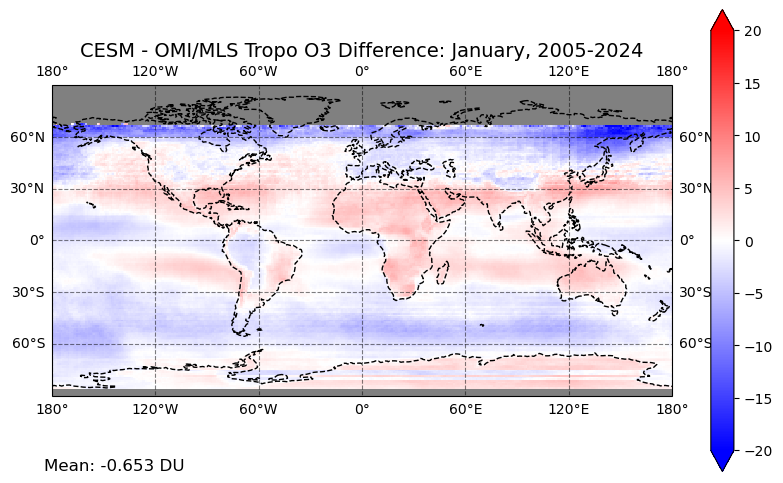

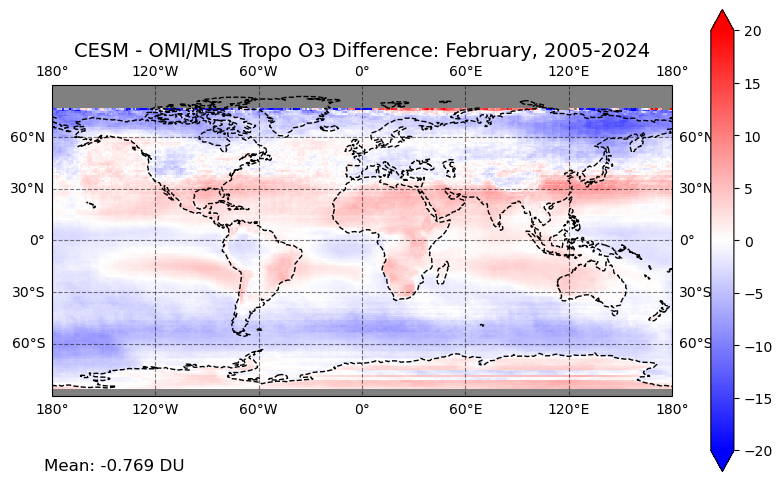

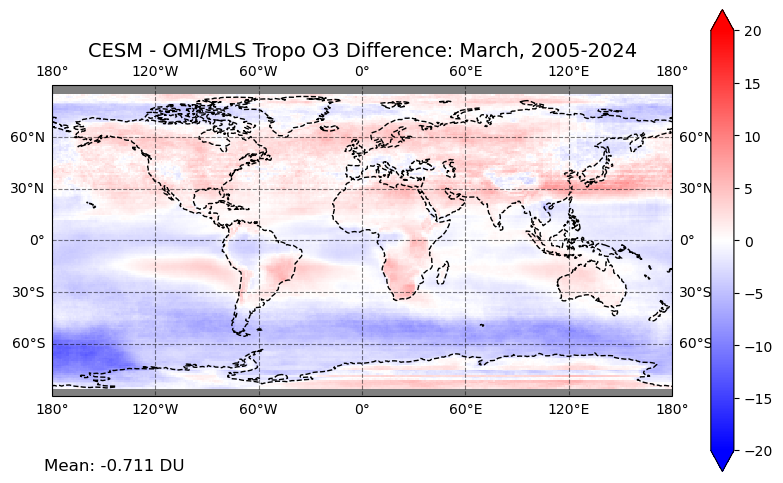

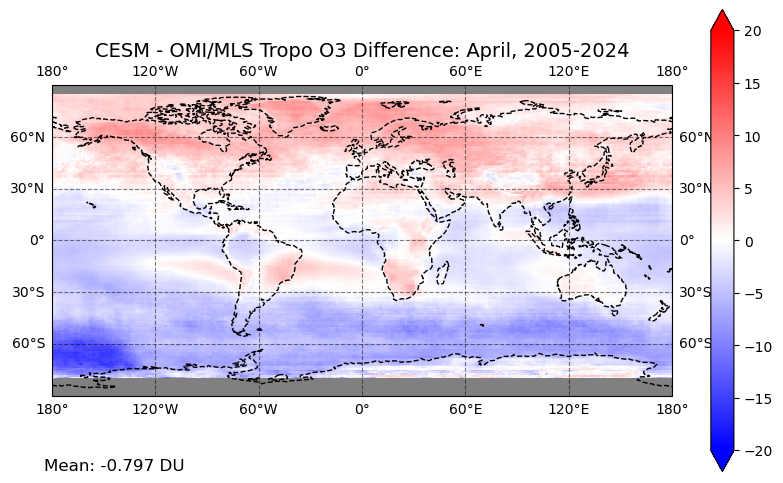

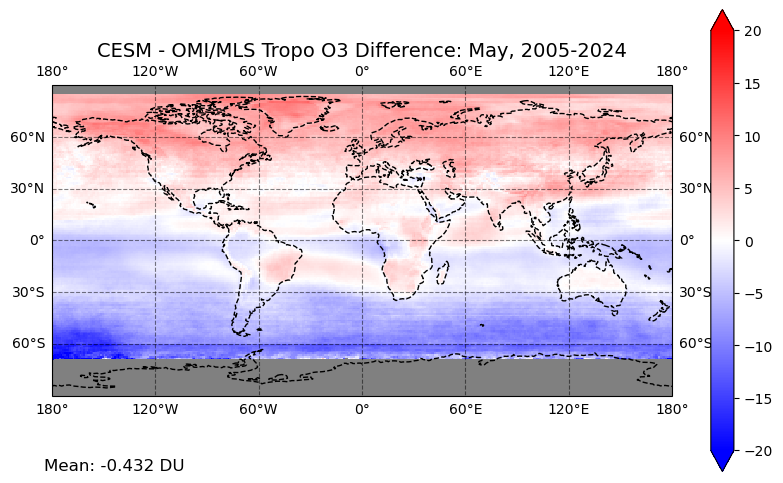

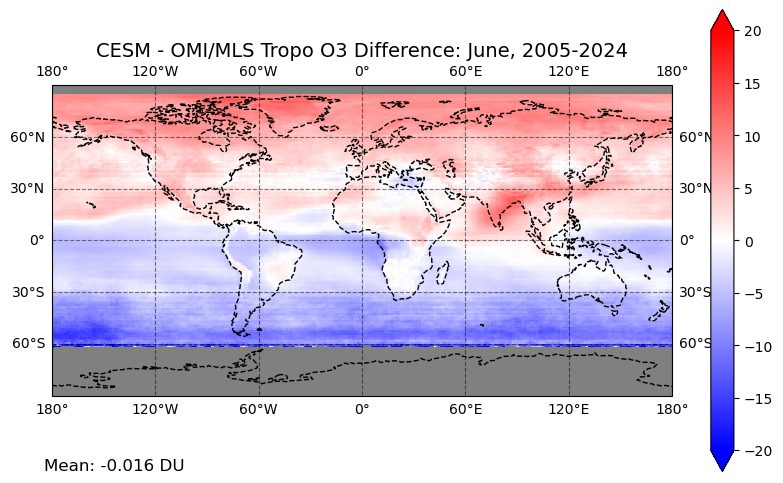

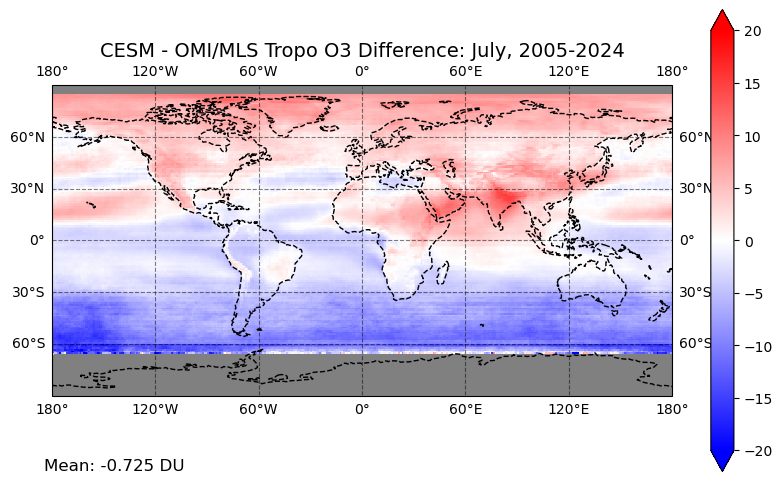

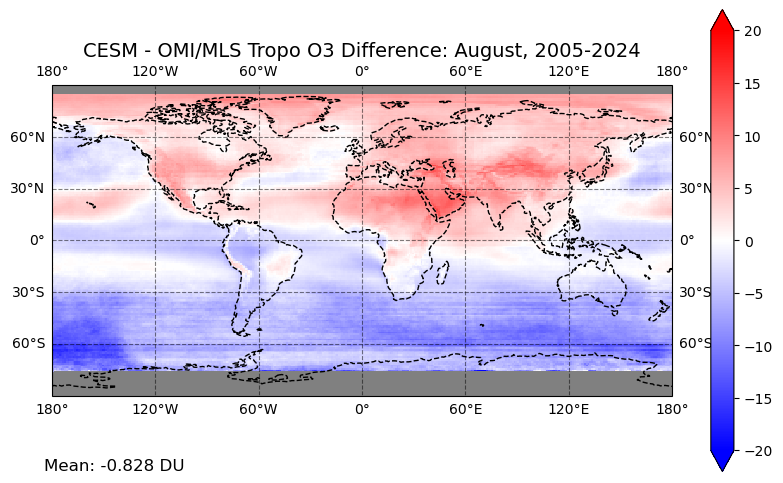

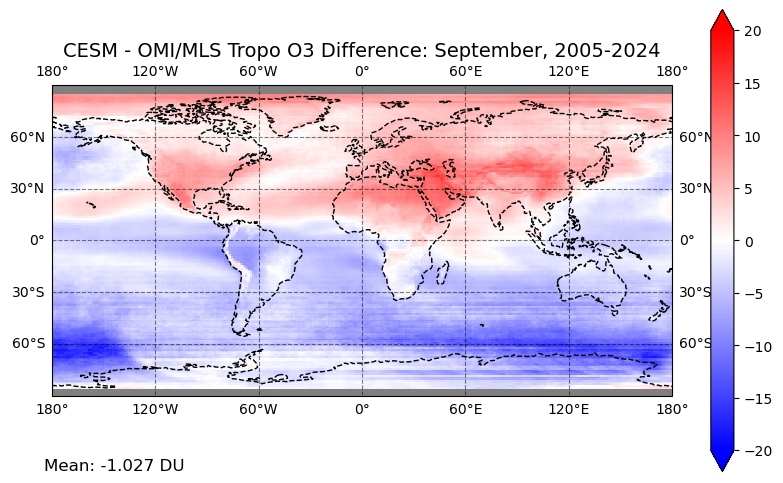

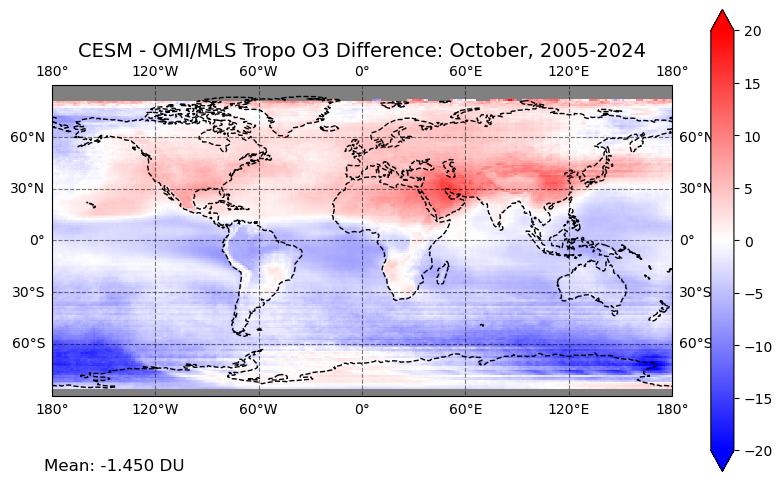

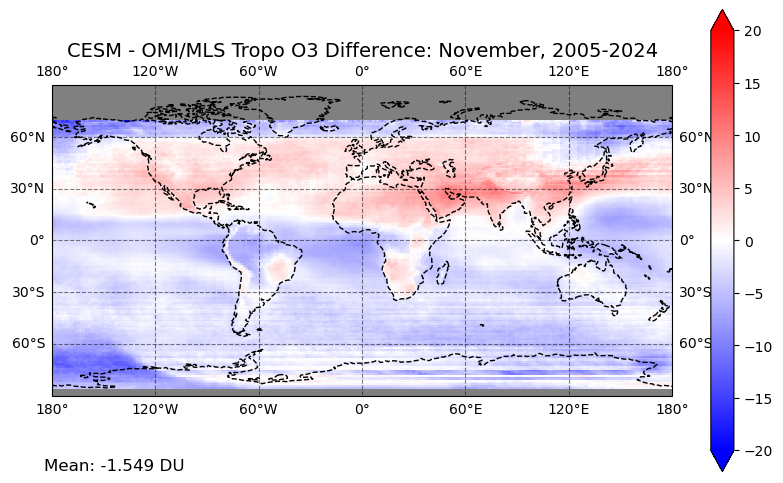

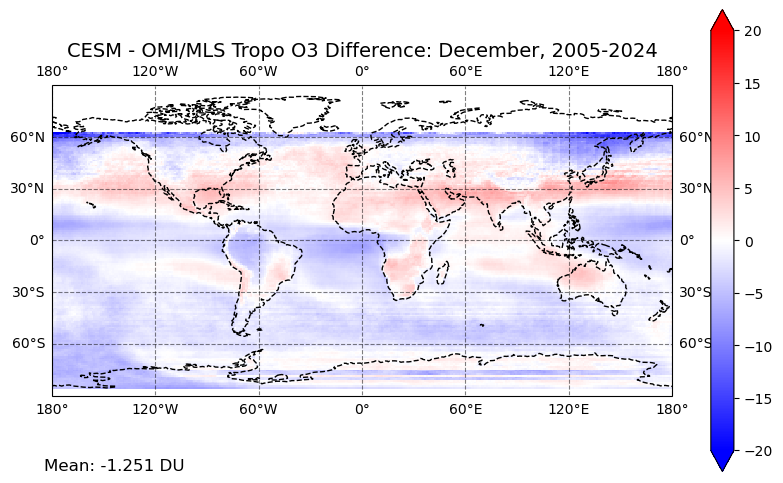

In [37]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] # for cycling through figures to create a gif

i = 0
for i in range(12):
    
    plt.figure(figsize=(10, 6))
    ax.set_facecolor('gray')
    ax = plt.axes(projection=ccrs.PlateCarree())
    difference[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=0), vmin = -20, vmax = 20, extend='both', cmap='bwr')
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_global()

    # adding gridlines
    ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    ax.set_title("CESM - OMI/MLS Tropo O3 Difference: " + month_list[i] + ", 2005-2024", fontsize=14)
    
    formatted_mean = f"{difference[i].mean().data:.3f}"

    ax.text(0.10, -0.25, 'Mean: ' + str(formatted_mean) + ' DU', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    

    #plt.savefig("figures/CESM_Diff-" + str(alphabet[i]))
    i+=1

    plt.show

In [38]:
import imageio
import os

def create_gif(image_folder, output_gif, duration):
    filenames = sorted([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    images = []
    for filename in filenames:
        if filename.startswith("CESM_Diff"):
            image_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(image_path))
    imageio.mimsave(output_gif, images, duration=duration)

image_dir = '/glade/u/home/mvoncyga/SOARS_2025/figures/'

#create_gif(image_dir, "Difference_Plot.gif", duration=1000)